In [1]:
"""
> First create your anaconda eviornment with the provided yaml file.
> If you don't want to create your own enviornment, make sure all modules are available in this cell and install 
  the ones you don't have seperately.
> The data set can be found in the repository, do not attempt to change the names of any directories.
> The weight files for the CNN models (.h5 files) can also be found. Do not change their paths.
> Now just execute the cells below one after the other.

"""

# Just a bunch of imports

import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.utils.np_utils import to_categorical
from keras.layers import Input
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing import image
from keras.applications.imagenet_utils import decode_predictions
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16, preprocess_input
from keras import layers
from keras.models import Model, Sequential
from keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping
print('Notebook run using keras:', keras.__version__)


import matplotlib.pyplot as plt
import numpy as np

from tqdm import tqdm
import cv2
import os
import shutil
import itertools
import imutils

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from skimage.io import imread

import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from plotly import tools


import math
import umap
from PIL import Image
from scipy import misc
from os import listdir
from os.path import isfile, join
from scipy import misc
from random import shuffle
from collections import Counter
from numpy import expand_dims

import tensorflow as tf


init_notebook_mode(connected=True)
RANDOM_SEED = 123
IMG_SIZE = (224,224)

Using TensorFlow backend.


Notebook run using keras: 2.3.1


In [17]:
# Loading the VGG16 base model first. Not loading our trained weights yet as we have not changed architecture.

vgg = VGG16(
    weights=None,
    include_top=False, 
    input_shape=IMG_SIZE + (3,)
)

vgg.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [18]:
# Changing the architecture for transfer learning

NUM_CLASSES = 1

vgg16 = Sequential()
vgg16.add(vgg)
vgg16.add(layers.Dropout(0.3))
vgg16.add(layers.Flatten())
vgg16.add(layers.Dropout(0.5))
vgg16.add(layers.Dense(NUM_CLASSES, activation='sigmoid'))

vgg16.layers[0].trainable = False

vgg16.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.Adam(lr=0.0003, beta_1=0.9, beta_2=0.999, decay=0.0, amsgrad=False),
              metrics=["accuracy"])

vgg16.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
dropout_3 (Dropout)          (None, 7, 7, 512)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 25088)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 25089     
Total params: 14,739,777
Trainable params: 25,089
Non-trainable params: 14,714,688
_________________________________________________________________


In [19]:
# Now loading our SPECT image trained weights.

vgg16.load_weights('./spect_trained_1.h5')

In [20]:
# Function to load data

def load_data(dir_path):
    """
    Load resized images as np.arrays to workspace
    """
    X = []
    y = []
    i = 0
    labels = dict()
    for path in tqdm(sorted(os.listdir(dir_path))):
        if not path.startswith('.'):
            labels[i] = path
            for file in os.listdir(dir_path + path):
                if not file.startswith('.'):
                    img = cv2.imread(dir_path + path + '/' + file)
                    X.append(img)
                    y.append(i)
            i += 1
    X = np.array(X)
    y = np.array(y)
    print(f'{len(X)} images loaded from {dir_path} directory.')
    return X, y, labels

In [21]:
# Load images into set variables

X_train_crop, y_train, labels = load_data('./TRAIN_CROP/')
X_test_crop, y_test, _ = load_data('./TEST_CROP/')
X_val_crop, y_val, _ = load_data('./VAL_CROP/')

100%|██████████| 2/2 [00:00<00:00, 163.01it/s]

516 images loaded from ./TRAIN_CROP/ directory.
65 images loaded from ./TEST_CROP/ directory.
64 images loaded from ./VAL_CROP/ directory.


In [22]:
#resize images to fit input layer of CNN ie 224x224

def preprocess_imgs(set_name, img_size):
    """
    Resize and apply VGG-16 preprocessing
    """
    set_new = []
    for img in set_name:
        img = cv2.resize(
            img,
            dsize=img_size,
            interpolation=cv2.INTER_CUBIC
        )
        set_new.append(preprocess_input(img))
    return np.array(set_new)

In [23]:
# Load resized images into final set variables

X_train_prep = preprocess_imgs(set_name=X_train_crop, img_size=IMG_SIZE)
X_test_prep = preprocess_imgs(set_name=X_test_crop, img_size=IMG_SIZE)
X_val_prep = preprocess_imgs(set_name=X_val_crop, img_size=IMG_SIZE)

In [24]:
# validate on val set
predictions = vgg16.predict(X_val_prep)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_val, predictions)
print('Val Accuracy = %.2f' % accuracy)

Val Accuracy = 0.97


In [47]:
# validate on test set
predictions = vgg16.predict(X_test_prep)
predictions = [1 if x>0.5 else 0 for x in predictions]

print(predictions)

accuracy = accuracy_score(y_test, predictions)
print('Test Accuracy = %.2f' % accuracy)

ValueError: Error when checking input: expected vgg16_input to have 4 dimensions, but got array with shape (224, 224, 3)

In [48]:
print(predictions)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1]


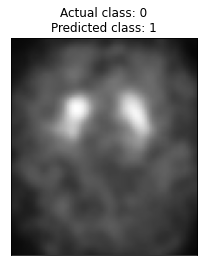

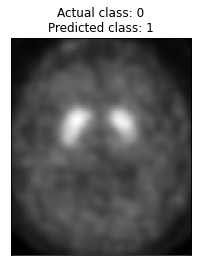

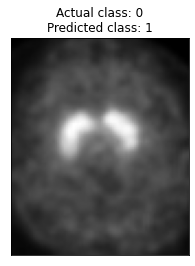

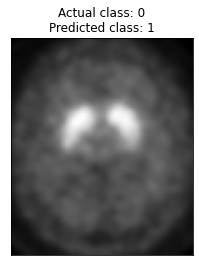

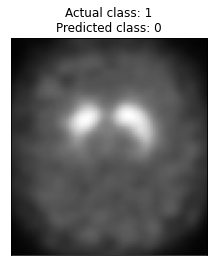

In [20]:
# Displaying the mis classifications

ind_list = np.argwhere((y_test == predictions) == False)[:, -1]
if ind_list.size == 0:
    print('There are no missclassified images.')
else:
    for i in ind_list:
        plt.figure()
        plt.imshow(X_test_crop[i])
        plt.xticks([])
        plt.yticks([])
        plt.title(f'Actual class: {y_val[i]}\nPredicted class: {predictions[i]}')
        plt.show()

In [26]:
#Import LIME

import lime
from lime import lime_image
from skimage.segmentation import mark_boundaries

# create lime ImageExplainer
explainer = lime_image.LimeImageExplainer()

# Choosing the image from X_test_prep set
image = X_test_prep[31].astype(np.uint8)

In [49]:
# Apple LIME to the image

explanation = explainer.explain_instance(image, vgg16.predict, top_labels=2, hide_color=0, num_samples=1000)

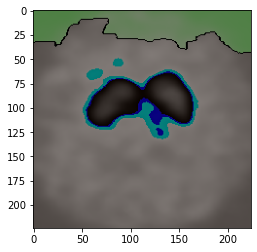

In [52]:
#Arguments for get_image_and_mask() method defined below

temp, mask = explanation.get_image_and_mask(0, positive_only=False, 
                                            num_features=5, 
                                            hide_rest=False)

"""
def get_image_and_mask(self, label, positive_only=True, negative_only=False, hide_rest=False,
                           num_features=5, min_weight=0.):
        Init function.
        Args:
            label: label to explain
            positive_only: if True, only take superpixels that positively contribute to
                the prediction of the label.
            negative_only: if True, only take superpixels that negatively contribute to
                the prediction of the label. If false, and so is positive_only, then both
                negativey and positively contributions will be taken.
                Both can't be True at the same time
            hide_rest: if True, make the non-explanation part of the return
                image gray
            num_features: number of superpixels to include in explanation
            min_weight: minimum weight of the superpixels to include in explanation
        Returns:
            (image, mask), where image is a 3d numpy array and mask is a 2d
            numpy array that can be used with
            skimage.segmentation.mark_boundaries
"""
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask).astype(np.uint8))